In [1]:
from tensorflow import keras
import keras.layers as layers
from keras.utils import to_categorical
from keras.models import Sequential,Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input,LeakyReLU,Conv2D, MaxPooling2D
from keras.datasets import mnist
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy, binary_crossentropy
import tensorflow as tf
import visualkeras
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import chain
import ast

In [34]:
def m2():
  model = Sequential()
     # Flatten layer 
  #model.add(Flatten())
  
  # The first fully connected layer 
  model.add(Dense(120, activation = 'relu', input_shape=(40,)))

  model.add(Dense(60, activation = 'relu'))
  
  # The output layer  
  model.add(Dense(1, activation = 'sigmoid'))

  opt = SGD(learning_rate=0.02)
  model.compile(loss = binary_crossentropy,
                optimizer = opt, 
                metrics = ['accuracy']) 
  
  return model

m2_instance = m2()

In [5]:
training_data_m2 = pd.read_csv('training_data_m2.csv')
training_data_m2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   img last conv layer       14000 non-null  object
 1   argument before fc layer  14000 non-null  object
 2   m1 pred                   14000 non-null  int64 
 3   label                     14000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 437.6+ KB


In [6]:
argument_float = []
for string_data in training_data_m2['argument before fc layer']:
    string_data = string_data.replace("[", "").replace("]", "").replace("\r\n", "").strip()
    values = string_data.split()
    float_values = [float(value) for value in values]
    argument_float.append(float_values)

training_data_m2['argument'] = argument_float
training_data_m2 = training_data_m2.drop(['argument before fc layer', 'img last conv layer', 'm1 pred'], axis = 1)
    


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(training_data_m2['argument'], 
                                                    training_data_m2['label'],
                                                    train_size=0.8
                                                    )


In [41]:
batch_size = 128
epochs = 50

def data_generator(data, labels):
    for inn, label in zip(data, labels):
        yield np.array(inn), [label]

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, Y_train),
    output_signature=(
        tf.TensorSpec(shape=(40,), dtype=tf.float32),
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
).batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, Y_test),
    output_signature=(
        tf.TensorSpec(shape=(40,), dtype=tf.float32),
        tf.TensorSpec(shape=(1,), dtype=tf.float32)
    )
).batch(batch_size)

In [ ]:
# Convert numpy arrays to TensorFlow tensors
"""
train_data_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_label_tensor = tf.convert_to_tensor(Y_train, dtype=tf.float32)

test_data_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
test_label_tensor = tf.convert_to_tensor(Y_test, dtype=tf.float32)

# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data_tensor, train_label_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data_tensor, test_label_tensor))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=len(train_data_tensor)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)
"""

In [31]:
sample_data, sample_label = next(iter(train_dataset))

# Check the shape of the sample data and label
print("Sample data shape:", sample_data.shape)
print("Sample label shape:", sample_label.shape)



Sample data shape: (128, 40)
Sample label shape: (128, 1)


In [35]:
"""
def preprocess_data(data, label):
    # Reshape data to match model input shape
    data = tf.reshape(data, (400,))
    return data, label


train_dataset = train_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)
"""

In [42]:

history = m2_instance.fit(
    train_dataset,
    epochs = epochs,
    validation_data = test_dataset
    )


Epoch 1/50
88/88 [==============================] - 2s 25ms/step - loss: 0.0995 - accuracy: 0.9659 - val_loss: 0.0919 - val_accuracy: 0.9661
Epoch 2/50
88/88 [==============================] - 2s 23ms/step - loss: 0.0986 - accuracy: 0.9662 - val_loss: 0.0913 - val_accuracy: 0.9661
Epoch 3/50
88/88 [==============================] - 2s 23ms/step - loss: 0.0979 - accuracy: 0.9666 - val_loss: 0.0908 - val_accuracy: 0.9664
Epoch 4/50
88/88 [==============================] - 2s 24ms/step - loss: 0.0972 - accuracy: 0.9668 - val_loss: 0.0903 - val_accuracy: 0.9675
Epoch 5/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0967 - accuracy: 0.9671 - val_loss: 0.0899 - val_accuracy: 0.9675
Epoch 6/50
88/88 [==============================] - 2s 22ms/step - loss: 0.0961 - accuracy: 0.9672 - val_loss: 0.0894 - val_accuracy: 0.9679
Epoch 7/50
88/88 [==============================] - 2s 24ms/step - loss: 0.0956 - accuracy: 0.9674 - val_loss: 0.0889 - val_accuracy: 0.9679
Epoch 8/50
88

In [43]:

prediction = m2_instance.predict(test_dataset)
dataset_length = 0
for _ in test_dataset:
    dataset_length += 1
print("Dataset length:", dataset_length)
print("Pred Length: ", len(prediction)) #????


22/22 [==============================] - 0s 20ms/step
Dataset length: 22
Pred Length:  2800


In [39]:
predicted_labels = (prediction > 0.5).astype(int)
count = 0
pred_lab = []
for x,y in zip(predicted_labels,Y_test):
    pred_lab.append(x)
    if x == y:
        count +=1
print(count/len(Y_test))

len(pred_lab)

0.9660714285714286


2800

In [13]:
len(prediction)

114400

Text(70.72222222222221, 0.5, 'True classes')

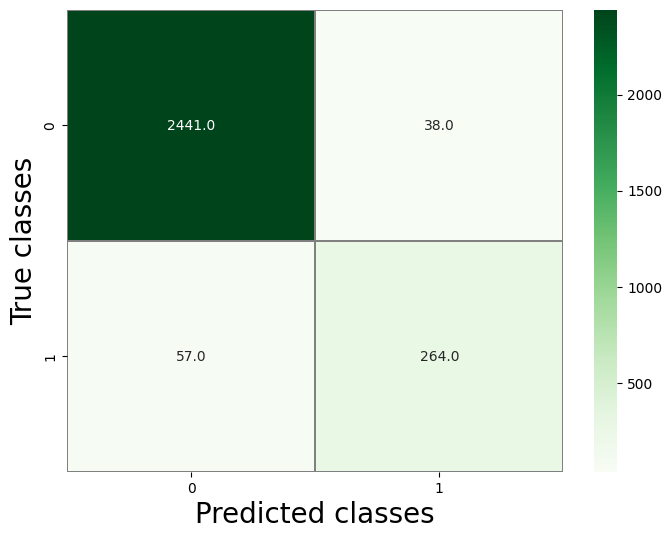

In [45]:
con_mat = confusion_matrix(Y_test, pred_lab)

plt.figure(figsize = (8,6))
sns.heatmap(con_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)